In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import argparse
import os
from collections import defaultdict

import torch

from habitat.config import Config as CN
from habitat.utils.visualizations.utils import images_to_video, observations_to_image

from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class, NavRLEnv
from habitat_baselines.config.default import get_config
from habitat_baselines.utils.common import batch_obs, generate_video
from habitat_baselines.utils.env_utils import construct_envs

from my_habitat_baselines.resnet_policy import PointNavResNetPolicy

In [3]:
jupyter_dir = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter"

jupyter_dir

'/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter'

In [5]:
#
# specify args
#

model_path = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models"

arg_string = ""

arg_string += "--model-path %s" % model_path

arg_string += \
"""
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000
"""

print(arg_string)

parser = argparse.ArgumentParser()
parser.add_argument("--model-path", type=str, required=True)
parser.add_argument("--sensors", type=str, required=True)
parser.add_argument("--hidden-size", type=int, required=True)
parser.add_argument(
    "--normalize-visual-inputs", type=int, required=True, choices=[0, 1]
)
parser.add_argument(
    "--backbone",
    type=str,
    required=True,
    choices=["resnet50", "se_resneXt50"],
)
parser.add_argument("--num-recurrent-layers", type=int, required=True)
parser.add_argument(
    "opts",
    default=None,
    nargs=argparse.REMAINDER,
    help="Modify config options from command line",
)
args = parser.parse_args(arg_string.split())

print(args)

--model-path /Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000

Namespace(backbone='resnet50', hidden_size=512, model_path='/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models', normalize_visual_inputs=1, num_re

In [6]:
#
# load and customize config
#

habitat_dir = "/Users/mroberts/code/github/habitat-lab"
os.chdir(habitat_dir)

config = get_config(
    "habitat_baselines/config/pointnav/ppo_pointnav.yaml"
)

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL = CN()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = None
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = None
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV = None
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV = None
config.TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY = None
config.freeze()

config.merge_from_list(args.opts)

# config.defrost()
# config.TASK_CONFIG.SIMULATOR.ACTION_SPACE_CONFIG = "pyrobotnoisy"
# config.freeze()

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = "ILQR"    # our pre-trained model lists "proportional" in the filename, so don't change to ILQR 
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 1.0 # our pre-trained model lists "0.5" in the filename, so don't change to 1.0
config.freeze()

config.defrost()
config.TASK_CONFIG.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = False
config.freeze()

config.defrost()
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ["*"]
config.TASK_CONFIG.DATASET.DATA_PATH = "data/datasets/pointnav/gibson/v2/val/val.json.gz" # don't have obstacle_1 scenes, so use Gibson instead
config.freeze()

config.defrost()
config.NUM_ENVIRONMENTS = 1
config.freeze()

config.defrost()
if args.sensors == "":
    config.SENSORS = []
else:
    config.SENSORS = args.sensors.split(",")
# TODO(akadian): collisions are not working
# config.TASK_CONFIG.TASK.MEASUREMENTS.append("COLLISIONS")
config.freeze()

print(config)

BASE_TASK_CONFIG_PATH: configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: -1
CMD_TRAILING_OPTS: []
ENV_NAME: NavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
FORCE_BLIND_POLICY: False
FORCE_TORCH_SINGLE_THREADED: True
LOG_FILE: train.log
LOG_INTERVAL: 25
NUM_CHECKPOINTS: 100
NUM_ENVIRONMENTS: 1
NUM_PROCESSES: -1
NUM_UPDATES: 10000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
PROFILING:
  CAPTURE_START_STEP: -1
  NUM_STEPS_TO_CAPT

In [7]:
#
# construct a single env instead of multiple envs for simplicity
#

env = NavRLEnv(config)

2021-11-17 20:46:04,776 Initializing dataset PointNav-v1
2021-11-17 20:46:04,797 initializing sim Sim-v0
I1117 20:46:09.232969 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sands.navmesh
I1117 20:46:04.799795 210587072 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1117 20:46:04.799834 210587072 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1117 20:46:04.799916 210587072 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1117 20:46:04.799957 210587072 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


h:365] <Physics Manager>::createFromJsonOrDefaultInternal : Proposing JSON name : ./data/default.physics_config.json from original name : ./data/default.physics_config.json | This file  does not exist.
I1117 20:46:04.800595 210587072 PhysicsAttributesManager.cpp:26] File (./data/default.physics_config.json) not found, so new default physics manager attributes created and registered.
I1117 20:46:04.800601 210587072 MetadataMediator.cpp:212] ::setActiveSceneDatasetName : Previous active dataset  changed to default successfully.
I1117 20:46:04.800604 210587072 MetadataMediator.cpp:183] ::setCurrPhysicsAttributesHandle : Old physics manager attributes  changed to ./data/default.physics_config.json successfully.
I1117 20:46:04.800609 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Sands.glb and dataset : default which is currently active dataset.
I1117 20:46:04.882611 210587072 ManagedFileBasedContainer.h

In [8]:
#
# create device
#

device = (
    torch.device("cuda:{}".format(config.TORCH_GPU_ID))
    if torch.cuda.is_available()
    else torch.device("cpu")
)

device

device(type='cpu')

In [9]:
#
# load model
#

def load_model(
    path,
    observation_space,
    action_space,
    hidden_size,
    normalize_visual_inputs,
    backbone,
    num_recurrent_layers,
    device,
):

    model = PointNavResNetPolicy(
        observation_space=observation_space,
        action_space=action_space,
        hidden_size=hidden_size,
        normalize_visual_inputs=normalize_visual_inputs,
        backbone=backbone,
        num_recurrent_layers=num_recurrent_layers,
        goal_sensor_uuid="pointgoal_with_gps_compass",
    )

    model.to(device)

    new_model_params = sum(
        [torch.numel(p) for _, p in model.named_parameters()]
    )

    saved_model = torch.load(path, map_location=device)
    saved_model_params = sum(
        [torch.numel(v) for k, v in saved_model["state_dict"].items()]
    )

    print(
        "new_model_params: {}, saved_model_params: {}".format(
            new_model_params, saved_model_params
        )
    )

    saved_model_state_dict = {}
    for k, v in saved_model["state_dict"].items():
        new_k = k.replace("actor_critic.", "")
        saved_model_state_dict[new_k] = v

    model.load_state_dict(saved_model_state_dict)

    return model



model_path = \
"/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/" + \
"job_19633792"                        + "." \
"sensor_RGB_SENSOR"                   + "." \
"train_data_gibson"                   + "." \
"noise_multiplier_0.5"                + "." \
"noise_model_controller_Proportional" + "." \
"agent_radius_0.20"                   + "." \
"success_reward_10.0"                 + "." \
"slack_reward_-0.01"                  + "." \
"collision_reward_0.0"                + "." \
"spl_max_collisions_500"              + "_" \
"ckpt.000000049"                      + \
".pth"
print(model_path)

action_space = env.action_space
observation_space = env.observation_space

model = load_model(
    path=model_path,
    observation_space=observation_space,
    action_space=action_space,
    hidden_size=args.hidden_size,
    normalize_visual_inputs=bool(args.normalize_visual_inputs),
    backbone=args.backbone,
    num_recurrent_layers=args.num_recurrent_layers,
    device=device,
)

model.eval()

model_params = 0
for k,v in model.state_dict().items():
    # print(k, torch.numel(v))
    model_params += torch.numel(v)
print(model_params)

saved_model = torch.load(model_path, map_location=device)

saved_model_params = 0
for k,v in saved_model["state_dict"].items():
    # print(k, torch.numel(v))
    saved_model_params += torch.numel(v)
print(saved_model_params)

/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/job_19633792.sensor_RGB_SENSOR.train_data_gibson.noise_multiplier_0.5.noise_model_controller_Proportional.agent_radius_0.20.success_reward_10.0.slack_reward_-0.01.collision_reward_0.0.spl_max_collisions_500_ckpt.000000049.pth
new_model_params: 12458053, saved_model_params: 12458060
12458060
12458060


DISTANCE_TO_GOAL
DISTANCE_TO: POINT
TYPE: DistanceToGoal
<class 'habitat.tasks.nav.nav.DistanceToGoal'>
distance_to_goal

994

NavigationEpisode(episode_id='11', scene_id='data/scene_datasets/gibson/Sands.glb', start_position=[3.198387861251831, 1.5990136861801147, 0.49142053723335266], start_rotation=[0, 0.912534060483753, 0, -0.4090007193844947], info={'geodesic_distance': 4.263117790222168}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fd7159e5ef0>, goals=[NavigationGoal(position=[-0.2237996757030487, 1.5990136861801147, -1.2859920263290405], radius=0.2)], start_room=None, shortest_paths=None)

{'distance_to_goal': 4.263117790222168, 'success': 0.0, 'spl': 0.0}

tensor([[0.]])


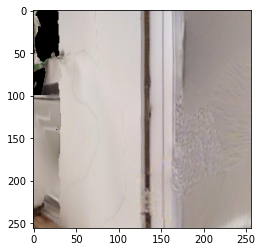

In [10]:
#
# initialization before main loop
#

metric_name = config.TASK_CONFIG.TASK.MEASUREMENTS[0]
metric_cfg = getattr(config.TASK_CONFIG.TASK, metric_name)
measure_type = baseline_registry.get_measure(metric_cfg.TYPE)
metric_uuid = measure_type(None, None)._get_uuid()

assert measure_type is not None, "invalid measurement type {}".format(metric_cfg.TYPE)

print(metric_name)
print(metric_cfg)
print(measure_type)
print(metric_uuid)
print()

observation = env.reset()

print(len(env.episodes))
print()

print(env.current_episode)
print()

print(env._env.get_metrics())
print()

observations = [observation]
batch = batch_obs(observations, device)

num_processes = 1

test_recurrent_hidden_states = torch.zeros(
    model.net.num_recurrent_layers,
    num_processes,
    args.hidden_size,
    device=device,
)
prev_actions = torch.zeros(
    num_processes, 1, device=device, dtype=torch.long
)
not_done_masks = torch.zeros(num_processes, 1, device=device)
print(not_done_masks)

current_episode_num_actions = 0
current_episode_reward = 0.0
current_episode_stats_actions = defaultdict(int)

stats_episodes = dict()  # dict of dicts that stores stats per episode

figsize(4,4)
imshow(observation["rgb"]);

In [11]:
max_num_actions_per_episode = 10000
num_episodes = 994

while len(stats_episodes) < num_episodes:

    #
    # main loop: choose action
    #

    with torch.no_grad():
        _, actions, _, test_recurrent_hidden_states = model.act(
            batch,
            test_recurrent_hidden_states,
            prev_actions,
            not_done_masks,
            deterministic=False,
        )

        prev_actions.copy_(actions)

    assert len(actions) == 1
    action = actions[0]
    
    # print(env.habitat_env.task.get_action_name(action.item()))

    #
    # main loop: perform action
    #

    observation, reward, done, info = env.step(action=action.item())

    #
    # main loop: update state
    #

    observations = [observation]
    batch = batch_obs(observations, device)

    dones = [done]
    not_done_masks = torch.tensor(
        [[0.0] if done else [1.0] for done in dones],
        dtype=torch.float,
        device=device,
    )

    current_episode_num_actions += 1
    current_episode_reward += reward
    current_episode_stats_actions[action.item()] += 1
    
    assert current_episode_num_actions < max_num_actions_per_episode
    
    if done:
        
        # record stats
        stats_episode = dict(info)
        stats_episode["reward"] = current_episode_reward
        stats_episode["stats_actions"] = dict(current_episode_stats_actions)
        
        # if len(stats_episodes) % 100 == 0:
        #     print("Episodes finished: {}".format(len(stats_episodes)))

        print("Episodes finished: {}".format(len(stats_episodes)))

        stats_episodes[ (env.current_episode.scene_id, env.current_episode.episode_id) ] = stats_episode
            
        # reset env
        observation = env.reset()
        observations = [observation]
        batch = batch_obs(observations, device)

        test_recurrent_hidden_states = torch.zeros(
            model.net.num_recurrent_layers,
            num_processes,
            args.hidden_size,
            device=device,
        )
        prev_actions = torch.zeros(
            num_processes, 1, device=device, dtype=torch.long
        )
        not_done_masks = torch.zeros(num_processes, 1, device=device)

        current_episode_num_actions = 0
        current_episode_reward = 0.0
        current_episode_stats_actions = defaultdict(int)

Episodes finished: 0
Episodes finished: 1
Episodes finished: 2
Episodes finished: 3
Episodes finished: 4
Episodes finished: 5
Episodes finished: 6
Episodes finished: 7
Episodes finished: 8
Episodes finished: 9
Episodes finished: 10
Episodes finished: 11
Episodes finished: 12
Episodes finished: 13
Episodes finished: 14
Episodes finished: 15
Episodes finished: 16
Episodes finished: 17
Episodes finished: 18
Episodes finished: 19
Episodes finished: 20
Episodes finished: 21
Episodes finished: 22
Episodes finished: 23
Episodes finished: 24
Episodes finished: 25
Episodes finished: 26
Episodes finished: 27
Episodes finished: 28
Episodes finished: 29
Episodes finished: 30
Episodes finished: 31


I1117 20:51:46.569913 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 20:51:46.569950 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 20:51:46.569954 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 20:51:46.569958 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 20:51:46.570101 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 20:51:46.630499 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 20:51:46.630546 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 20:51:46.654866 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eastville.glb and dataset : default which is currently active dataset.
I1117 20:51:46.747723 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Eastville.glb changed to proposed scene_instance.json filename : data/s

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
Episodes finished: 32
Episodes finished: 33
Episodes finished: 34
Episodes finished: 35
Episodes finished: 36
Episodes finished: 37
Episodes finished: 38
Episodes finished: 39
Episodes finished: 40
Episodes finished: 41
Episodes finished: 42
Episodes finished: 43
Episodes finished: 44
Episodes finished: 45
Episodes finished: 46
Episodes finished: 47
Episodes finished: 48
Episodes finished: 49
Episodes finished: 50
Episodes finished: 51
Episodes finished: 52
Episodes finished: 53
Episodes finished: 54
Episodes finished: 55
Episodes finished: 56
Rend

I1117 20:56:09.888164 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 20:56:14.351749 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Mosquito.navmesh
I1117 20:56:09.888192 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 20:56:09.888197 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 20:56:09.888200 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 20:56:09.888345 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 20:56:09.940240 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 20:56:09.940279 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 20:56:09.941777 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Mosquito.glb and dataset : default which is currently active dataset.
I1117 20:56:10.094686 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filen

Episodes finished: 57
Episodes finished: 58
Episodes finished: 59
Episodes finished: 60
Episodes finished: 61
Episodes finished: 62
Episodes finished: 63
Episodes finished: 64
Episodes finished: 65
Episodes finished: 66
Episodes finished: 67
Episodes finished: 68
Episodes finished: 69
Episodes finished: 70
Episodes finished: 71
Episodes finished: 72
Episodes finished: 73
Episodes finished: 74
Episodes finished: 75
Episodes finished: 76
Episodes finished: 77
Episodes finished: 78
Episodes finished: 79
Episodes finished: 80


I1117 21:01:31.345463 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:01:31.345489 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:01:31.345494 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:01:31.345496 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:01:31.345636 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:01:31.397838 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:01:31.397881 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:01:31.399214 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Scioto.glb and dataset : default which is currently active dataset.
I1117 21:01:31.527655 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Scioto.glb changed to proposed scene_instance.json filename : data/scene_d

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


iator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneAttributes or StageAttributes named : data/scene_datasets/gibson/Scioto.glb so loading/creating a new StageAttributes with this name, and then creating a SceneAttributes with the same name that references this stage.
I1117 21:01:31.527686 210587072 ManagedFileBasedContainer.h:210] <Stage Template>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Scioto.glb changed to proposed stage_config.json filename : data/scene_datasets/gibson/Scioto.stage_config.json
I1117 21:01:31.527691 210587072 AttributesManagerBase.h:365] <Stage Template>::createFromJsonOrDefaultInternal : Proposing JSON name : data/scene_datasets/gibson/Scioto.stage_config.json from original name : data/scene_datasets/gibson/Scioto.glb | This file  does not exist.
I1117 21:01:31.527752 210587072 AbstractObjectAttributesManagerBase.h:183] File (data/scene_datasets/gibson/Scioto.glb) exists but is not a recognized config file

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


7 21:01:35.437974 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Scioto.glb yields 1 candidates.  Using data/scene_datasets/gibson/Scioto.glb.
I1117 21:01:35.438006 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Scioto.glb' specified in Scene Attributes exists in dataset library.
I1117 21:01:35.438026 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 21:01:35.438046 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Scioto.glb yields 1 candidates.  Using data/scene_datasets/gibson/Scioto.glb.
I1117 21:01:35.438086 210587072 SceneDatasetAttributes.cpp:45] ::addNewS

Episodes finished: 81
Episodes finished: 82
Episodes finished: 83
Episodes finished: 84
Episodes finished: 85
Episodes finished: 86
Episodes finished: 87
Episodes finished: 88
Episodes finished: 89
Episodes finished: 90
Episodes finished: 91
Episodes finished: 92
Episodes finished: 93
Episodes finished: 94
Episodes finished: 95
Episodes finished: 96
Episodes finished: 97
Episodes finished: 98
Episodes finished: 99
Episodes finished: 100
Episodes finished: 101
Episodes finished: 102
Episodes finished: 103
Episodes finished: 104
Episodes finished: 105
Episodes finished: 106
Episodes finished: 107
Episodes finished: 108
Episodes finished: 109
Episodes finished: 110
Episodes finished: 111
Episodes finished: 112


I1117 21:07:00.634778 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:07:00.634805 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:07:00.634809 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:07:00.634814 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:07:00.634951 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:07:00.686355 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:07:00.686398 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:07:04.848730 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sisters.navmesh
I1117 21:07:00.688391 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Sisters.glb and dataset : default which is currently active dataset.
I1117 21:07:00.818588 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filenam

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


ers.glb.
I1117 21:07:00.818975 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Sisters.glb 
I1117 21:07:00.818987 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Sisters.glb
I1117 21:07:04.847666 210587072 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Sisters.glb
W1117 21:07:04.847699 210587072 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I1117 21:07:04.847708 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Sisters.glb yields 1 candidates.  Using data/scene_datasets/gibson/Sisters.glb.
I1117 21:07:04.847720 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Sisters.glb' specified in Scene Attri

Episodes finished: 113
Episodes finished: 114
Episodes finished: 115
Episodes finished: 116
Episodes finished: 117
Episodes finished: 118
Episodes finished: 119
Episodes finished: 120
Episodes finished: 121
Episodes finished: 122
Episodes finished: 123
Episodes finished: 124
Episodes finished: 125
Episodes finished: 126
Episodes finished: 127
Episodes finished: 128
Episodes finished: 129
Episodes finished: 130
Episodes finished: 131
Episodes finished: 132
Episodes finished: 133
Episodes finished: 134
Episodes finished: 135
Episodes finished: 136
Episodes finished: 137
Episodes finished: 138
Episodes finished: 139
Episodes finished: 140
Episodes finished: 141
Episodes finished: 142
Episodes finished: 143
Episodes finished: 144
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


I1117 21:11:36.490422 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:11:40.858350 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Cantwell.navmesh
I1117 21:11:36.490453 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:11:36.490456 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:11:36.490460 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:11:36.490607 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:11:36.539364 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:11:36.539403 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:11:36.540809 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Cantwell.glb and dataset : default which is currently active dataset.
I1117 21:11:36.667121 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filen

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


gnized config filename extension, so new default Stage Template attributes created and registered.
I1117 21:11:36.667248 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Cantwell.glb' specified in Scene Attributes exists in dataset library.
I1117 21:11:36.667253 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 21:11:36.667259 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Cantwell.navmesh
I1117 21:11:36.667265 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Cantwell.navmesh
I1117 21:11:36.667425 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 21:11:36.667433 210587072 SceneGraph

Episodes finished: 145
Episodes finished: 146
Episodes finished: 147
Episodes finished: 148
Episodes finished: 149
Episodes finished: 150
Episodes finished: 151
Episodes finished: 152
Episodes finished: 153
Episodes finished: 154
Episodes finished: 155
Episodes finished: 156
Episodes finished: 157
Episodes finished: 158
Episodes finished: 159
Episodes finished: 160
Episodes finished: 161
Episodes finished: 162
Episodes finished: 163
Episodes finished: 164
Episodes finished: 165
Episodes finished: 166
Episodes finished: 167
Episodes finished: 168
Episodes finished: 169
Episodes finished: 170
Episodes finished: 171
Episodes finished: 172
Episodes finished: 173
Episodes finished: 174
Episodes finished: 175
Episodes finished: 176
Episodes finished: 177
Episodes finished: 178
Episodes finished: 179
Episodes finished: 180
Episodes finished: 181


I1117 21:17:10.732379 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:17:10.732407 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:17:10.732412 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:17:10.732415 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:17:10.732564 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:17:10.791206 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:17:10.791254 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:17:10.793020 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Ribera.glb and dataset : default which is currently active dataset.
I1117 21:17:10.918504 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Ribera.glb changed to proposed scene_instance.json filename : data/scene_d

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


10.918882 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Ribera.glb 
I1117 21:17:10.918895 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Ribera.glb
I1117 21:17:15.071760 210587072 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Ribera.glb
W1117 21:17:15.071812 210587072 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I1117 21:17:15.071822 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Ribera.glb yields 1 candidates.  Using data/scene_datasets/gibson/Ribera.glb.
I1117 21:17:15.071852 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Ribera.glb' specified in Scene Attributes exists in dataset lib

Episodes finished: 182
Episodes finished: 183
Episodes finished: 184
Episodes finished: 185
Episodes finished: 186
Episodes finished: 187
Episodes finished: 188
Episodes finished: 189
Episodes finished: 190
Episodes finished: 191
Episodes finished: 192
Episodes finished: 193
Episodes finished: 194
Episodes finished: 195
Episodes finished: 196
Episodes finished: 197
Episodes finished: 198
Episodes finished: 199
Episodes finished: 200
Episodes finished: 201
Episodes finished: 202
Episodes finished: 203
Episodes finished: 204
Episodes finished: 205
Episodes finished: 206
Episodes finished: 207
Episodes finished: 208
Episodes finished: 209
Episodes finished: 210
Episodes finished: 211
Episodes finished: 212
Episodes finished: 213
Episodes finished: 214
Episodes finished: 215
Episodes finished: 216
Episodes finished: 217
Episodes finished: 218
Episodes finished: 219
Episodes finished: 220
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
U

I1117 21:22:38.063766 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:22:38.063793 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:22:38.063797 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:22:38.063800 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:22:42.185201 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Swormville.navmesh
I1117 21:22:38.063941 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:22:38.118858 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:22:38.118898 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:22:38.120893 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Swormville.glb and dataset : default which is currently active dataset.
I1117 21:22:38.228412 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : F

Episodes finished: 221
Episodes finished: 222
Episodes finished: 223
Episodes finished: 224
Episodes finished: 225
Episodes finished: 226
Episodes finished: 227
Episodes finished: 228
Episodes finished: 229
Episodes finished: 230
Episodes finished: 231
Episodes finished: 232
Episodes finished: 233
Episodes finished: 234
Episodes finished: 235
Episodes finished: 236
Episodes finished: 237
Episodes finished: 238
Episodes finished: 239
Episodes finished: 240
Episodes finished: 241
Episodes finished: 242
Episodes finished: 243
Episodes finished: 244
Episodes finished: 245
Episodes finished: 246
Episodes finished: 247
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22


I1117 21:27:13.036132 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Eudora.navmesh
I1117 21:27:11.897897 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:27:11.897925 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:27:11.897929 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:27:11.897933 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:27:11.898095 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:27:12.011514 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:27:12.011557 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:27:12.012986 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eudora.glb and dataset : default which is currently active dataset.
I1117 21:27:12.120602 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename 

Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
Episodes finished: 248
Episodes finished: 249
Episodes finished: 250
Episodes finished: 251
Episodes finished: 252
Episodes finished: 253
Episodes finished: 254
Episodes finished: 255
Episodes finished: 256
Episodes finished: 257
Episodes finished: 258
Episodes finished: 259
Episodes finished: 260
Episodes finished: 261
Episodes finished: 262
Episodes finished: 263
Episodes finished: 264
Episodes finished: 265
Episodes finished: 266
Episodes finished: 267
Episodes finished: 268
Episodes finished: 269
Episodes finished: 270
Episodes finished: 271
Episodes finished: 272
Episodes finished: 273
Episodes finished: 274
Episodes finished: 275
Episodes fin

I1117 21:33:06.715615 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:33:06.715641 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:33:06.715646 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:33:06.715649 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:33:06.715791 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:33:06.730490 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:33:06.730528 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:33:06.732229 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Pablo.glb and dataset : default which is currently active dataset.
I1117 21:33:07.633256 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Pablo.navmesh
I1117 21:33:06.784072 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : 

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


pecified Light key : -no_lights-
I1117 21:33:06.784440 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Pablo.glb and dataset : default which is currently active dataset.
I1117 21:33:06.784458 210587072 Simulator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Pablo.glb with render asset : data/scene_datasets/gibson/Pablo.glb and collision asset : data/scene_datasets/gibson/Pablo.glb
I1117 21:33:06.784471 210587072 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1117 21:33:06.784474 210587072 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Pablo.glb.
I1117 21:33:06.784477 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Pablo.glb 
I1117 21:33:06.784505 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Pablo.glb
I1117 21:33:07

Episodes finished: 292
Episodes finished: 293
Episodes finished: 294
Episodes finished: 295
Episodes finished: 296
Episodes finished: 297
Episodes finished: 298
Episodes finished: 299
Episodes finished: 300
Episodes finished: 301
Episodes finished: 302
Episodes finished: 303
Episodes finished: 304
Episodes finished: 305
Episodes finished: 306
Episodes finished: 307
Episodes finished: 308
Episodes finished: 309
Episodes finished: 310
Episodes finished: 311
Episodes finished: 312
Episodes finished: 313
Episodes finished: 314
Episodes finished: 315
Episodes finished: 316
Episodes finished: 317
Episodes finished: 318
Episodes finished: 319
Episodes finished: 320
Episodes finished: 321
Episodes finished: 322
Episodes finished: 323
Episodes finished: 324
Episodes finished: 325
Episodes finished: 326
Episodes finished: 327
Episodes finished: 328
Episodes finished: 329
Episodes finished: 330
Episodes finished: 331
Episodes finished: 332
Episodes finished: 333
Episodes finished: 334
Episodes fi

I1117 21:38:18.744246 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:38:18.744273 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:38:18.744278 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:38:18.744282 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:38:18.744429 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:38:18.759564 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:38:18.759603 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:38:18.761181 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Elmira.glb and dataset : default which is currently active dataset.
I1117 21:38:19.669069 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Elmira.navmesh
I1117 21:38:18.814471 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename 

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


name : data/scene_datasets/gibson/Elmira.stage_config.json from original name : data/scene_datasets/gibson/Elmira.glb | This file  does not exist.
I1117 21:38:18.814568 210587072 AbstractObjectAttributesManagerBase.h:183] File (data/scene_datasets/gibson/Elmira.glb) exists but is not a recognized config filename extension, so new default Stage Template attributes created and registered.
I1117 21:38:18.814599 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Elmira.glb' specified in Scene Attributes exists in dataset library.
I1117 21:38:18.814602 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 21:38:18.814610 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Elmira.navmesh


Episodes finished: 343
Episodes finished: 344
Episodes finished: 345
Episodes finished: 346
Episodes finished: 347
Episodes finished: 348
Episodes finished: 349
Episodes finished: 350
Episodes finished: 351
Episodes finished: 352
Episodes finished: 353
Episodes finished: 354
Episodes finished: 355
Episodes finished: 356
Episodes finished: 357
Episodes finished: 358
Episodes finished: 359
Episodes finished: 360
Episodes finished: 361
Episodes finished: 362
Episodes finished: 363
Episodes finished: 364
Episodes finished: 365
Episodes finished: 366
Episodes finished: 367
Episodes finished: 368
Episodes finished: 369
Episodes finished: 370
Episodes finished: 371
Episodes finished: 372
Episodes finished: 373
Episodes finished: 374
Episodes finished: 375
Episodes finished: 376
Episodes finished: 377
Episodes finished: 378
Episodes finished: 379
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


I1117 21:42:28.342553 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:42:28.342582 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:42:28.342587 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:42:28.342590 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:42:28.342736 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:42:28.357515 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:42:28.357550 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:42:28.360505 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Greigsville.glb and dataset : default which is currently active dataset.
I1117 21:42:28.414580 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/gibson/Greigsville.glb changed to proposed scene_instance.json filename : da

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


nternal : Proposing JSON name : data/scene_datasets/gibson/Greigsville.stage_config.json from original name : data/scene_datasets/gibson/Greigsville.glb | This file  does not exist.
I1117 21:42:28.414680 210587072 AbstractObjectAttributesManagerBase.h:183] File (data/scene_datasets/gibson/Greigsville.glb) exists but is not a recognized config filename extension, so new default Stage Template attributes created and registered.
I1117 21:42:28.414711 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Greigsville.glb' specified in Scene Attributes exists in dataset library.
I1117 21:42:28.414716 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 21:42:28.414723 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance

Episodes finished: 380
Episodes finished: 381
Episodes finished: 382
Episodes finished: 383
Episodes finished: 384
Episodes finished: 385
Episodes finished: 386
Episodes finished: 387
Episodes finished: 388
Episodes finished: 389
Episodes finished: 390
Episodes finished: 391
Episodes finished: 392
Episodes finished: 393
Episodes finished: 394
Episodes finished: 395
Episodes finished: 396
Episodes finished: 397
Episodes finished: 398
Episodes finished: 399
Episodes finished: 400
Episodes finished: 401
Episodes finished: 402
Episodes finished: 403
Episodes finished: 404
Episodes finished: 405
Episodes finished: 406
Episodes finished: 407
Episodes finished: 408
Episodes finished: 409
Episodes finished: 410
Episodes finished: 411
Episodes finished: 412
Episodes finished: 413
Episodes finished: 414
Episodes finished: 415
Episodes finished: 416
Episodes finished: 417


I1117 21:47:03.399844 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Denmark.navmesh
I1117 21:46:59.206346 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:46:59.206375 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:46:59.206380 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:46:59.206383 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:46:59.206532 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:46:59.221323 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:46:59.221362 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:46:59.222654 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Denmark.glb and dataset : default which is currently active dataset.
I1117 21:46:59.278049 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filenam

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


ark.glb
I1117 21:46:59.278414 210587072 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1117 21:46:59.278417 210587072 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Denmark.glb.
I1117 21:46:59.278420 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Denmark.glb 
I1117 21:46:59.278432 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Denmark.glb
I1117 21:47:03.399159 210587072 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Denmark.glb
W1117 21:47:03.399176 210587072 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I1117 21:47:03.399186 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Denmark.glb yields 1 candidates.  Using data/scen

Episodes finished: 418
Episodes finished: 419
Episodes finished: 420
Episodes finished: 421
Episodes finished: 422
Episodes finished: 423
Episodes finished: 424
Episodes finished: 425
Episodes finished: 426
Episodes finished: 427
Episodes finished: 428
Episodes finished: 429
Episodes finished: 430
Episodes finished: 431
Episodes finished: 432
Episodes finished: 433
Episodes finished: 434
Episodes finished: 435
Episodes finished: 436
Episodes finished: 437
Episodes finished: 438
Episodes finished: 439
Episodes finished: 440
Episodes finished: 441
Episodes finished: 442
Episodes finished: 443
Episodes finished: 444
Episodes finished: 445
Episodes finished: 446
Episodes finished: 447
Episodes finished: 448
Episodes finished: 449
Episodes finished: 450
Episodes finished: 451
Episodes finished: 452
Episodes finished: 453
Episodes finished: 454
Episodes finished: 455
Episodes finished: 456
Episodes finished: 457
Episodes finished: 458
Episodes finished: 459
Episodes finished: 460
Episodes fi

I1117 21:51:47.055876 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:51:48.086511 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Edgemere.navmesh
I1117 21:51:47.055904 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:51:47.055909 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:51:47.055912 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:51:47.056066 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:51:47.111804 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:51:47.111845 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:51:47.113310 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Edgemere.glb and dataset : default which is currently active dataset.
I1117 21:51:47.226892 210587072 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filen

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


gnized config filename extension, so new default Stage Template attributes created and registered.
I1117 21:51:47.227023 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Edgemere.glb' specified in Scene Attributes exists in dataset library.
I1117 21:51:47.227028 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 21:51:47.227037 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Edgemere.navmesh
I1117 21:51:47.227042 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Edgemere.navmesh
I1117 21:51:47.227130 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 21:51:47.227138 210587072 SceneGraph

Episodes finished: 476
Episodes finished: 477
Episodes finished: 478
Episodes finished: 479
Episodes finished: 480
Episodes finished: 481
Episodes finished: 482
Episodes finished: 483
Episodes finished: 484
Episodes finished: 485
Episodes finished: 486
Episodes finished: 487
Episodes finished: 488
Episodes finished: 489
Episodes finished: 490
Episodes finished: 491
Episodes finished: 492
Episodes finished: 493
Episodes finished: 494
Episodes finished: 495
Episodes finished: 496
Episodes finished: 497
Episodes finished: 498
Episodes finished: 499
Episodes finished: 500
Episodes finished: 501
Episodes finished: 502
Episodes finished: 503
Episodes finished: 504
Episodes finished: 505
Episodes finished: 506
Episodes finished: 507
Episodes finished: 508
Episodes finished: 509
Episodes finished: 510
Episodes finished: 511
Episodes finished: 512
Episodes finished: 513
Episodes finished: 514
Episodes finished: 515
Episodes finished: 516
Episodes finished: 517
Episodes finished: 518
Episodes fi

I1117 21:56:27.653023 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 21:56:31.962332 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sands.navmesh
I1117 21:56:27.653050 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 21:56:27.653055 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 21:56:27.653059 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 21:56:27.653208 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 21:56:27.668267 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 21:56:27.668303 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 21:56:27.669817 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Sands.glb and dataset : default which is currently active dataset.
I1117 21:56:27.723469 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAtt

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 21:56:31.972014 210587072 PathFinder.cpp:382] Building navmesh with 154x145 cells
I1117 21:56:32.053613 210587072 PathFinder.cpp:652] Created navmesh with 140 vertices 68 polygons
I1117 21:56:32.054425 210587072 Simulator.cpp:790] reconstruct navmesh successful


Episodes finished: 520
Episodes finished: 521
Episodes finished: 522
Episodes finished: 523
Episodes finished: 524
Episodes finished: 525
Episodes finished: 526
Episodes finished: 527
Episodes finished: 528
Episodes finished: 529
Episodes finished: 530
Episodes finished: 531
Episodes finished: 532
Episodes finished: 533
Episodes finished: 534
Episodes finished: 535
Episodes finished: 536
Episodes finished: 537
Episodes finished: 538
Episodes finished: 539
Episodes finished: 540
Episodes finished: 541
Episodes finished: 542
Episodes finished: 543
Episodes finished: 544
Episodes finished: 545
Episodes finished: 546
Episodes finished: 547
Episodes finished: 548
Episodes finished: 549
Episodes finished: 550
Episodes finished: 551
Episodes finished: 552
Episodes finished: 553
Episodes finished: 554
Episodes finished: 555
Episodes finished: 556


I1117 22:02:16.699480 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Eastville.navmesh
I1117 22:02:12.305006 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:02:12.305034 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:02:12.305038 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:02:12.305042 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:02:12.305181 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:02:12.354198 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:02:12.354240 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:02:12.355618 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eastville.glb and dataset : default which is currently active dataset.
I1117 22:02:12.481021 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for 

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


pp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Eastville.glb' specified in Scene Attributes exists in dataset library.
I1117 22:02:12.481048 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:02:12.481056 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Eastville.navmesh
I1117 22:02:12.481070 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Eastville.navmesh
I1117 22:02:12.481225 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 22:02:12.481233 210587072 SceneGraph.h:85] Created DrawableGroup: 
I1117 22:02:12.481240 210587072 Simulator.cpp:243] ::setSceneInstanceAttributes : SceneInstance : data/scene_datasets/gib

Episodes finished: 557
Episodes finished: 558
Episodes finished: 559
Episodes finished: 560
Episodes finished: 561
Episodes finished: 562
Episodes finished: 563
Episodes finished: 564
Episodes finished: 565
Episodes finished: 566
Episodes finished: 567
Episodes finished: 568
Episodes finished: 569
Episodes finished: 570
Episodes finished: 571
Episodes finished: 572
Episodes finished: 573
Episodes finished: 574
Episodes finished: 575
Episodes finished: 576
Episodes finished: 577
Episodes finished: 578
Episodes finished: 579
Episodes finished: 580
Episodes finished: 581
Episodes finished: 582
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


I1117 22:06:31.003664 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:06:31.003691 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:06:31.003695 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:06:31.003700 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:06:31.003839 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:06:31.056286 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:06:31.056332 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:06:31.058172 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Mosquito.glb and dataset : default which is currently active dataset.
I1117 22:06:31.196246 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Mosquito.glb yields 1 candidates.  Using data/scene_data

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 22:06:35.487107 210587072 PathFinder.cpp:382] Building navmesh with 224x469 cells
I1117 22:06:35.614336 210587072 PathFinder.cpp:652] Created navmesh with 588 vertices 287 polygons
I1117 22:06:35.614993 210587072 Simulator.cpp:790] reconstruct navmesh successful


Episodes finished: 583
Episodes finished: 584
Episodes finished: 585
Episodes finished: 586
Episodes finished: 587
Episodes finished: 588
Episodes finished: 589
Episodes finished: 590
Episodes finished: 591
Episodes finished: 592
Episodes finished: 593
Episodes finished: 594
Episodes finished: 595
Episodes finished: 596
Episodes finished: 597
Episodes finished: 598
Episodes finished: 599
Episodes finished: 600
Episodes finished: 601
Episodes finished: 602
Episodes finished: 603


I1117 22:11:06.336328 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:11:10.655567 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Scioto.navmesh
I1117 22:11:06.336354 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:11:06.336361 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:11:06.336366 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:11:06.336558 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:11:06.390044 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:11:06.390084 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:11:06.391008 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Scioto.glb and dataset : default which is currently active dataset.
I1117 22:11:06.506963 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


posed Semantic Scene Descriptor filename : data/scene_datasets/gibson/Scioto.scn
E1117 22:11:06.507268 210587072 SemanticScene.h:155] ::loadSemanticSceneDescriptor : File data/scene_datasets/gibson/Scioto.scn does not exist.  Aborting load.
W1117 22:11:06.507277 210587072 Simulator.cpp:267] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name data/scene_datasets/gibson/Scioto.scn : exist : 0 : loaded as expected type : 0
I1117 22:11:06.507333 210587072 Simulator.cpp:316] ::createSceneInstance : Using scene instance-specified Light key : -no_lights-
I1117 22:11:06.507341 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Scioto.glb and dataset : default which is currently active dataset.
I1117 22:11:06.507364 210587072 Simulator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Scioto.glb with render asset : data/scene_datasets/g

Episodes finished: 604
Episodes finished: 605
Episodes finished: 606
Episodes finished: 607
Episodes finished: 608
Episodes finished: 609
Episodes finished: 610
Episodes finished: 611
Episodes finished: 612
Episodes finished: 613
Episodes finished: 614
Episodes finished: 615
Episodes finished: 616
Episodes finished: 617
Episodes finished: 618
Episodes finished: 619
Episodes finished: 620
Episodes finished: 621
Episodes finished: 622
Episodes finished: 623
Episodes finished: 624
Episodes finished: 625
Episodes finished: 626
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.


I1117 22:15:49.749330 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:15:54.006484 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sisters.navmesh
I1117 22:15:49.749372 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:15:49.749377 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:15:49.749379 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:15:49.749509 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:15:49.801843 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:15:49.801884 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:15:49.803333 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Sisters.glb and dataset : default which is currently active dataset.
I1117 22:15:49.905072 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for Scen

OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


 ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Sisters.glb' specified in Scene Attributes exists in dataset library.
I1117 22:15:49.905099 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:15:49.905109 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Sisters.navmesh
I1117 22:15:49.905122 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Sisters.navmesh
I1117 22:15:49.905256 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 22:15:49.905264 210587072 SceneGraph.h:85] Created DrawableGroup: 
I1117 22:15:49.905272 210587072 Simulator.cpp:243] ::setSceneInstanceAttributes : SceneInstance : data/scene_datasets/gibson/Sisters.

Episodes finished: 627
Episodes finished: 628
Episodes finished: 629
Episodes finished: 630
Episodes finished: 631
Episodes finished: 632
Episodes finished: 633
Episodes finished: 634
Episodes finished: 635
Episodes finished: 636
Episodes finished: 637
Episodes finished: 638
Episodes finished: 639
Episodes finished: 640
Episodes finished: 641
Episodes finished: 642
Episodes finished: 643
Episodes finished: 644
Episodes finished: 645
Episodes finished: 646
Episodes finished: 647
Episodes finished: 648
Episodes finished: 649
Episodes finished: 650
Episodes finished: 651
Episodes finished: 652
Episodes finished: 653
Episodes finished: 654
Episodes finished: 655
Episodes finished: 656
Episodes finished: 657
Episodes finished: 658
Episodes finished: 659
Episodes finished: 660
Episodes finished: 661
Episodes finished: 662
Episodes finished: 663
Episodes finished: 664


I1117 22:20:17.038844 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:20:21.448873 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Cantwell.navmesh
I1117 22:20:17.038874 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:20:17.038879 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:20:17.038882 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:20:17.039032 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:20:17.092226 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:20:17.092267 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:20:17.093231 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Cantwell.glb and dataset : default which is currently active dataset.
I1117 22:20:17.207152 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for Sc

Episodes finished: 665
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Cantwell.glb' specified in Scene Attributes exists in dataset library.
I1117 22:20:17.207185 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:20:17.207195 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Cantwell.navmesh
I1117 22:20:17.207206 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Cantwell.navmesh
I1117 22:20:17.207352 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 22:20:17.207360 210587072 SceneGraph.h:85] Created DrawableGroup: 
I1117 22:20:17.207367 210587072 Simulator.cpp:243] ::setSceneInstanceAttributes : SceneInstance : data/scene_datasets/gibson/Ca

Episodes finished: 666
Episodes finished: 667
Episodes finished: 668
Episodes finished: 669
Episodes finished: 670
Episodes finished: 671
Episodes finished: 672
Episodes finished: 673
Episodes finished: 674
Episodes finished: 675
Episodes finished: 676
Episodes finished: 677
Episodes finished: 678
Episodes finished: 679
Episodes finished: 680
Episodes finished: 681
Episodes finished: 682
Episodes finished: 683
Episodes finished: 684
Episodes finished: 685
Episodes finished: 686
Episodes finished: 687
Episodes finished: 688
Episodes finished: 689
Episodes finished: 690
Episodes finished: 691
Episodes finished: 692
Episodes finished: 693
Episodes finished: 694
Episodes finished: 695
Episodes finished: 696
Episodes finished: 697
Episodes finished: 698
Episodes finished: 699


I1117 22:23:44.839511 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:23:48.529264 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Ribera.navmesh
I1117 22:23:44.839537 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:23:44.839542 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:23:44.839545 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:23:44.839687 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:23:44.898181 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:23:44.898224 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:23:44.900429 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Ribera.glb and dataset : default which is currently active dataset.
I1117 22:23:45.041236 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 22:23:48.535163 210587072 PathFinder.cpp:382] Building navmesh with 127x175 cells
I1117 22:23:48.574527 210587072 PathFinder.cpp:652] Created navmesh with 100 vertices 50 polygons
I1117 22:23:48.574544 210587072 Simulator.cpp:790] reconstruct navmesh successful


Episodes finished: 700
Episodes finished: 701
Episodes finished: 702
Episodes finished: 703
Episodes finished: 704
Episodes finished: 705
Episodes finished: 706
Episodes finished: 707
Episodes finished: 708
Episodes finished: 709
Episodes finished: 710
Episodes finished: 711
Episodes finished: 712
Episodes finished: 713
Episodes finished: 714
Episodes finished: 715
Episodes finished: 716
Episodes finished: 717
Episodes finished: 718
Episodes finished: 719
Episodes finished: 720
Episodes finished: 721
Episodes finished: 722
Episodes finished: 723
Episodes finished: 724
Episodes finished: 725
Episodes finished: 726
Episodes finished: 727
Episodes finished: 728
Episodes finished: 729
Episodes finished: 730
Episodes finished: 731


I1117 22:27:13.820170 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:27:13.820196 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:27:13.820201 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:27:13.820204 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:27:17.534940 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Swormville.navmesh
I1117 22:27:13.820330 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:27:13.871811 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:27:13.871850 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:27:13.873482 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Swormville.glb and dataset : default which is currently active dataset.
I1117 22:27:14.013402 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default fo

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


es.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:27:14.013438 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Swormville.navmesh
I1117 22:27:14.013450 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Swormville.navmesh
I1117 22:27:14.013567 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 22:27:14.013576 210587072 SceneGraph.h:85] Created DrawableGroup: 
I1117 22:27:14.013581 210587072 Simulator.cpp:243] ::setSceneInstanceAttributes : SceneInstance : data/scene_datasets/gibson/Swormville.glb proposed Semantic Scene Descriptor filename : data/scene_datasets/gibson/Swormville.scn
E1117 22:27:14.013588 210587072 SemanticScene.h:155] ::loadSemanticSceneDescriptor : File data/scene_datasets/gibson/Sworm

Episodes finished: 732
Episodes finished: 733
Episodes finished: 734
Episodes finished: 735
Episodes finished: 736
Episodes finished: 737
Episodes finished: 738
Episodes finished: 739
Episodes finished: 740
Episodes finished: 741
Episodes finished: 742
Episodes finished: 743
Episodes finished: 744
Episodes finished: 745
Episodes finished: 746
Episodes finished: 747
Episodes finished: 748
Episodes finished: 749
Episodes finished: 750
Episodes finished: 751
Episodes finished: 752
Episodes finished: 753
Episodes finished: 754
Episodes finished: 755
Episodes finished: 756
Episodes finished: 757
Episodes finished: 758
Episodes finished: 759
Episodes finished: 760
Episodes finished: 761
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label


I1117 22:31:50.860240 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:31:50.860267 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:31:50.860272 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:31:50.860275 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:31:50.860414 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:31:50.915861 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:31:50.915904 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:31:50.916980 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eudora.glb and dataset : default which is currently active dataset.
I1117 22:31:51.054432 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Eudora.glb yields 1 candidates.  Using data/scene_datasets

Episodes finished: 762
Episodes finished: 763
Episodes finished: 764
Episodes finished: 765
Episodes finished: 766
Episodes finished: 767
Episodes finished: 768
Episodes finished: 769
Episodes finished: 770
Episodes finished: 771
Episodes finished: 772
Episodes finished: 773
Episodes finished: 774
Episodes finished: 775
Episodes finished: 776
Episodes finished: 777
Episodes finished: 778
Episodes finished: 779
Episodes finished: 780
Episodes finished: 781
Episodes finished: 782
Episodes finished: 783
Episodes finished: 784
Episodes finished: 785
Episodes finished: 786


I1117 22:36:26.063664 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Pablo.navmesh
I1117 22:36:25.242789 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:36:25.242817 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:36:25.242821 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:36:25.242825 210587072 SceneGraph.h:25] Deconstructing SceneGraph


Episodes finished: 787
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 22:36:25.242955 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:36:25.257916 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:36:25.257944 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:36:25.259322 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Pablo.glb and dataset : default which is currently active dataset.
I1117 22:36:25.317518 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Pablo.glb yields 1 candidates.  Using data/scene_datasets/gibson/Pablo.glb.
I1117 22:36:25.317540 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Pablo.glb' specified in Scene Attributes exists in dataset library.
I1117 22:36:25.317544 210587072 SceneDatasetAttributes.cpp:85] ::addNewS

Episodes finished: 788
Episodes finished: 789
Episodes finished: 790
Episodes finished: 791
Episodes finished: 792
Episodes finished: 793
Episodes finished: 794
Episodes finished: 795
Episodes finished: 796
Episodes finished: 797
Episodes finished: 798
Episodes finished: 799
Episodes finished: 800
Episodes finished: 801
Episodes finished: 802
Episodes finished: 803
Episodes finished: 804
Episodes finished: 805
Episodes finished: 806
Episodes finished: 807


I1117 22:38:37.981837 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:38:37.981863 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:38:37.981866 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:38:37.981869 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:38:38.831010 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Elmira.navmesh
I1117 22:38:37.982002 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:38:37.996753 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:38:37.996800 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:38:37.998575 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Elmira.glb and dataset : default which is currently active dataset.
I1117 22:38:38.058463 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


adStage : start load render asset data/scene_datasets/gibson/Elmira.glb.
I1117 22:38:38.058712 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Elmira.glb 
I1117 22:38:38.062451 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Elmira.glb
I1117 22:38:38.829962 210587072 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_datasets/gibson/Elmira.glb
W1117 22:38:38.829998 210587072 Simulator.cpp:427] 
---
Simulator::createSceneInstance : The active scene does not contain semantic annotations. 
---
I1117 22:38:38.830009 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Elmira.glb yields 1 candidates.  Using data/scene_datasets/gibson/Elmira.glb.
I1117 22:38:38.830024 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/

Episodes finished: 808
Episodes finished: 809
Episodes finished: 810
Episodes finished: 811
Episodes finished: 812
Episodes finished: 813
Episodes finished: 814
Episodes finished: 815
Episodes finished: 816
Episodes finished: 817
Episodes finished: 818
Episodes finished: 819
Episodes finished: 820
Episodes finished: 821
Episodes finished: 822
Episodes finished: 823
Episodes finished: 824
Episodes finished: 825
Episodes finished: 826
Episodes finished: 827
Episodes finished: 828
Episodes finished: 829
Episodes finished: 830
Episodes finished: 831
Episodes finished: 832
Episodes finished: 833
Episodes finished: 834
Episodes finished: 835
Episodes finished: 836
Episodes finished: 837
Episodes finished: 838
Episodes finished: 839
Episodes finished: 840
Episodes finished: 841


I1117 22:42:38.303148 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:42:38.303174 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:42:38.303179 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:42:38.303182 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:42:39.139546 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Greigsville.navmesh
I1117 22:42:38.303318 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:42:38.317627 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:42:38.317656 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:42:38.318967 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Greigsville.glb and dataset : default which is currently active dataset.
I1117 22:42:38.380045 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default 

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


setAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Greigsville.glb' specified in Scene Attributes exists in dataset library.
I1117 22:42:39.138794 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:42:39.138805 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Greigsville.glb yields 1 candidates.  Using data/scene_datasets/gibson/Greigsville.glb.
I1117 22:42:39.138813 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Greigsville.glb' specified in Scene Attributes exists in dataset library.
I1117 22:42:39.138815 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Datas

Episodes finished: 842
Episodes finished: 843
Episodes finished: 844
Episodes finished: 845
Episodes finished: 846
Episodes finished: 847
Episodes finished: 848
Episodes finished: 849
Episodes finished: 850
Episodes finished: 851
Episodes finished: 852
Episodes finished: 853
Episodes finished: 854
Episodes finished: 855
Episodes finished: 856
Episodes finished: 857
Episodes finished: 858
Episodes finished: 859
Episodes finished: 860
Episodes finished: 861
Episodes finished: 862
Episodes finished: 863
Episodes finished: 864
Episodes finished: 865
Episodes finished: 866
Episodes finished: 867
Episodes finished: 868
Episodes finished: 869
Episodes finished: 870
Episodes finished: 871
Episodes finished: 872
Episodes finished: 873
Episodes finished: 874


I1117 22:45:00.555567 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:45:00.555593 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:45:00.555598 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:45:00.555600 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:45:00.555748 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:45:00.570398 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:45:00.570427 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:45:00.573581 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Denmark.glb and dataset : default which is currently active dataset.
I1117 22:45:03.953682 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Denmark.navmesh
I1117 22:45:00.627391 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for Scen

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


t new simulator config for scene/stage : data/scene_datasets/gibson/Denmark.glb and dataset : default which is currently active dataset.
I1117 22:45:00.627636 210587072 Simulator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Denmark.glb with render asset : data/scene_datasets/gibson/Denmark.glb and collision asset : data/scene_datasets/gibson/Denmark.glb
I1117 22:45:00.627648 210587072 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1117 22:45:00.627652 210587072 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Denmark.glb.
I1117 22:45:00.627655 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Denmark.glb 
I1117 22:45:00.627667 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Denmark.glb
I1117 22:45:03.952956 210587072 Simulator.cpp:392] ::createSceneInstance : Successfully loaded stage named : data/scene_da

Episodes finished: 875
Episodes finished: 876
Episodes finished: 877
Episodes finished: 878
Episodes finished: 879
Episodes finished: 880
Episodes finished: 881
Episodes finished: 882
Episodes finished: 883
Episodes finished: 884
Episodes finished: 885
Episodes finished: 886
Episodes finished: 887
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 22:45:50.341974 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:45:50.342000 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:45:50.342003 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:45:50.342007 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:45:50.342149 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:45:50.395474 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:45:50.395519 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:45:50.396979 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Edgemere.glb and dataset : default which is currently active dataset.
I1117 22:45:50.536691 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Edgemere.glb yields 1 candidates.  Using data/scene_data

Episodes finished: 888
Episodes finished: 889
Episodes finished: 890
Episodes finished: 891
Episodes finished: 892
Episodes finished: 893
Episodes finished: 894
Episodes finished: 895
Episodes finished: 896
Episodes finished: 897
Episodes finished: 898
Episodes finished: 899
Episodes finished: 900
Episodes finished: 901
Episodes finished: 902
Episodes finished: 903
Episodes finished: 904
Episodes finished: 905
Episodes finished: 906
Episodes finished: 907
Episodes finished: 908
Episodes finished: 909
Episodes finished: 910
Episodes finished: 911
Episodes finished: 912
Episodes finished: 913
Episodes finished: 914
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22


I1117 22:47:57.620374 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:47:57.620398 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:47:57.620402 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:47:57.620405 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:48:01.506453 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sands.navmesh
I1117 22:47:57.620560 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:47:57.634930 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:47:57.634965 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:47:57.636010 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Sands.glb and dataset : default which is currently active dataset.
I1117 22:47:57.688804 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAtt

Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


n/Sands.glb' specified in Scene Attributes exists in dataset library.
I1117 22:48:01.505343 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:48:01.505357 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Sands.glb yields 1 candidates.  Using data/scene_datasets/gibson/Sands.glb.
I1117 22:48:01.505364 210587072 SceneDatasetAttributes.cpp:45] ::addNewSceneInstanceToDataset : Dataset : 'default' : Stage Attributes 'data/scene_datasets/gibson/Sands.glb' specified in Scene Attributes exists in dataset library.
I1117 22:48:01.505367 210587072 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 22:48:01.505380 210587072 S

Episodes finished: 915
Episodes finished: 916
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 22:48:28.480638 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:48:28.480664 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:48:28.480669 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:48:28.480671 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:48:28.480809 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:48:28.549733 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:48:28.549774 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:48:28.552248 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eastville.glb and dataset : default which is currently active dataset.
I1117 22:48:28.672823 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Eastville.glb yields 1 candidates.  Using data/scene_da

Episodes finished: 917
Episodes finished: 918
Episodes finished: 919
Episodes finished: 920
Episodes finished: 921
Episodes finished: 922
Episodes finished: 923
Episodes finished: 924
Episodes finished: 925
Episodes finished: 926
Episodes finished: 927
Episodes finished: 928
Episodes finished: 929
Episodes finished: 930
Episodes finished: 931
Episodes finished: 932
Episodes finished: 933
Episodes finished: 934
Episodes finished: 935
Episodes finished: 936


I1117 22:51:18.750710 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:51:18.750738 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:51:18.750742 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:51:18.750746 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:51:18.750887 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:51:18.803105 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:51:18.803148 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:51:18.804847 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Mosquito.glb and dataset : default which is currently active dataset.
I1117 22:51:18.929569 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Mosquito.glb yields 1 candidates.  Using data/scene_data

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
Episodes finished: 937
Episodes finished: 938
Episodes finished: 939
Episodes finished: 940
Episodes finished: 941
Episodes finished: 942
Episodes finished: 943
Episodes finished: 944
Episodes finished: 945
Episodes finished: 946
Episodes finished: 947
Episodes finished: 948
Episodes finished: 949
Episodes finished: 950
Episodes finished: 951
Episodes finished: 952
Episodes finished: 953
Episodes finished: 954
Episodes finished: 955
Episodes finished: 956
Episodes finished: 957
Episodes finished: 958
Episodes finished: 959
Episodes finished: 960
Ep

I1117 22:56:39.723308 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Scioto.navmesh
I1117 22:56:35.774139 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:56:35.774165 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:56:35.774169 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:56:35.774173 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:56:35.774314 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:56:35.827190 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:56:35.827232 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:56:35.828693 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Scioto.glb and dataset : default which is currently active dataset.
I1117 22:56:35.947057 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify
Episodes finished: 963
Episodes finished: 964
Episodes finished: 965
Episodes finished: 966
Episodes finished: 967
Episodes finished: 968
Episodes finished: 969
Episodes finished: 970
Episodes finished: 971
Episodes finished: 972
Episodes finished: 973
Episodes finished: 974
Episodes finished: 975
Episodes finished: 976
Episodes finished: 977
Episodes finished: 978


I1117 22:59:33.523000 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 22:59:33.523025 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 22:59:33.523030 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 22:59:33.523032 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 22:59:33.523190 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 22:59:33.577510 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 22:59:33.577553 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 22:59:33.580235 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Swormville.glb and dataset : default which is currently active dataset.
I1117 22:59:37.332749 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Swormville.navmesh
I1117 22:59:33.700438 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default fo

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


SimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Swormville.glb and dataset : default which is currently active dataset.
I1117 22:59:33.700716 210587072 Simulator.cpp:374] ::createSceneInstance : Start to load stage named : data/scene_datasets/gibson/Swormville.glb with render asset : data/scene_datasets/gibson/Swormville.glb and collision asset : data/scene_datasets/gibson/Swormville.glb
I1117 22:59:33.700728 210587072 ResourceManager.cpp:249] ::loadStage : Not loading semantic mesh
I1117 22:59:33.700732 210587072 ResourceManager.cpp:277] ::loadStage : start load render asset data/scene_datasets/gibson/Swormville.glb.
I1117 22:59:33.700735 210587072 ResourceManager.cpp:691] ::loadStageInternal : Attempting to load stage data/scene_datasets/gibson/Swormville.glb 
I1117 22:59:33.700748 210587072 ResourceManager.cpp:1281] Importing Basis files as BC3 for Swormville.glb
I1117 22:59:37.331869 210587072 Simulator.cpp:392] ::createSceneInstance :

Episodes finished: 979
Episodes finished: 980
Episodes finished: 981
Episodes finished: 982
Episodes finished: 983
Episodes finished: 984
Episodes finished: 985
Episodes finished: 986
Episodes finished: 987
Episodes finished: 988
Episodes finished: 989
Episodes finished: 990
Episodes finished: 991
Episodes finished: 992


I1117 23:01:30.425554 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 23:01:30.425580 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 23:01:30.425585 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 23:01:30.425588 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 23:01:31.368754 12527 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Eudora.navmesh
I1117 23:01:30.425732 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 23:01:30.481707 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 23:01:30.481750 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 23:01:30.482928 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Eudora.glb and dataset : default which is currently active dataset.
I1117 23:01:30.602399 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneA

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


NewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1117 23:01:30.602444 210587072 Simulator.cpp:198] ::setSceneInstanceAttributes : Navmesh file location in scene instance : data/scene_datasets/gibson/Eudora.navmesh
I1117 23:01:30.602458 210587072 Simulator.cpp:205] ::setSceneInstanceAttributes : Loading navmesh from data/scene_datasets/gibson/Eudora.navmesh
I1117 23:01:30.602562 210587072 Simulator.cpp:208] ::setSceneInstanceAttributes : Navmesh Loaded.
I1117 23:01:30.602571 210587072 SceneGraph.h:85] Created DrawableGroup: 
I1117 23:01:30.602576 210587072 Simulator.cpp:243] ::setSceneInstanceAttributes : SceneInstance : data/scene_datasets/gibson/Eudora.glb proposed Semantic Scene Descriptor filename : data/scene_datasets/gibson/Eudora.scn
E1117 23:01:30.602584 210587072 SemanticScene.h:155] ::loadSemanticSceneDescriptor : File data/scene_datasets/gibson/Eudora.scn does not exist.  Aborting 

Episodes finished: 993
Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


I1117 23:01:45.755446 210587072 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I1117 23:01:45.755475 210587072 SemanticScene.h:43] Deconstructing SemanticScene
I1117 23:01:45.755479 210587072 SceneManager.h:25] Deconstructing SceneManager
I1117 23:01:45.755482 210587072 SceneGraph.h:25] Deconstructing SceneGraph
I1117 23:01:45.755616 210587072 Sensor.cpp:69] Deconstructing Sensor
I1117 23:01:45.769474 210587072 Renderer.cpp:71] Deconstructing Renderer
I1117 23:01:45.769501 210587072 WindowlessContext.h:17] Deconstructing WindowlessContext
I1117 23:01:45.770414 210587072 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/gibson/Denmark.glb and dataset : default which is currently active dataset.
I1117 23:01:45.828243 210587072 MetadataMediator.cpp:262] ::getSceneAttributesByName : Query dataset : default for SceneAttributes named : data/scene_datasets/gibson/Denmark.glb yields 1 candidates.  Using data/scene_datase

In [19]:
valid = np.array([ np.isfinite(s[1]["distance_to_goal"]) for s in stats_episodes.items() ])

print(np.count_nonzero(valid) / valid.shape[0])
print(np.count_nonzero(valid))
print(valid.shape[0])

success = np.array([ s[1]["success"] for s in stats_episodes.items() ])
spl = np.array([ s[1]["spl"] for s in stats_episodes.items() ])

success = success[valid]
spl = spl[valid]

print(np.mean(success))
print(np.mean(spl))

0.9688128772635815
963
994
0.5233644859813084
0.3452799501432847


In [20]:
stats_episodes

{('data/scene_datasets/gibson/Sands.glb',
  '11'): {'distance_to_goal': 4.025516986846924, 'success': 0.0, 'spl': 0.0, 'reward': -4.762399196624699, 'stats_actions': {3: 74,
   1: 360,
   2: 66}},
 ('data/scene_datasets/gibson/Sands.glb',
  '8'): {'distance_to_goal': 6.952826976776123, 'success': 0.0, 'spl': 0.0, 'reward': -0.12999999999999998, 'stats_actions': {3: 12,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '46'): {'distance_to_goal': 0.11131948232650757, 'success': 1.0, 'spl': 0.4793062694445675, 'reward': 3.8577531266212444, 'stats_actions': {1: 205,
   2: 55,
   3: 61,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '52'): {'distance_to_goal': 0.12101437896490097, 'success': 1.0, 'spl': 0.7559826010567394, 'reward': 4.217937695086002, 'stats_actions': {1: 11,
   3: 9,
   2: 3,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '57'): {'distance_to_goal': 5.031500339508057, 'success': 0.0, 'spl': 0.0, 'reward': -3.662921428680387, 'stats_actions': {2: 48,
 